In [84]:
!pip install wandb

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from keras.utils import np_utils
from numpy import random
from random import seed
import math
import wandb
from keras.datasets import mnist
from sklearn import metrics
import seaborn as sn
from PIL import Image
import PIL
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [86]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [87]:
# Split data for cross validation
x_val = x_train[54000:]
y_val = y_train[54000:]
x_train = x_train[:54000]
y_train = y_train[:54000]  

In [88]:
print("x_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)
print(y_train)

x_train original shape (54000, 28, 28)
y_train original shape (54000,)
[9 0 0 ... 5 3 9]


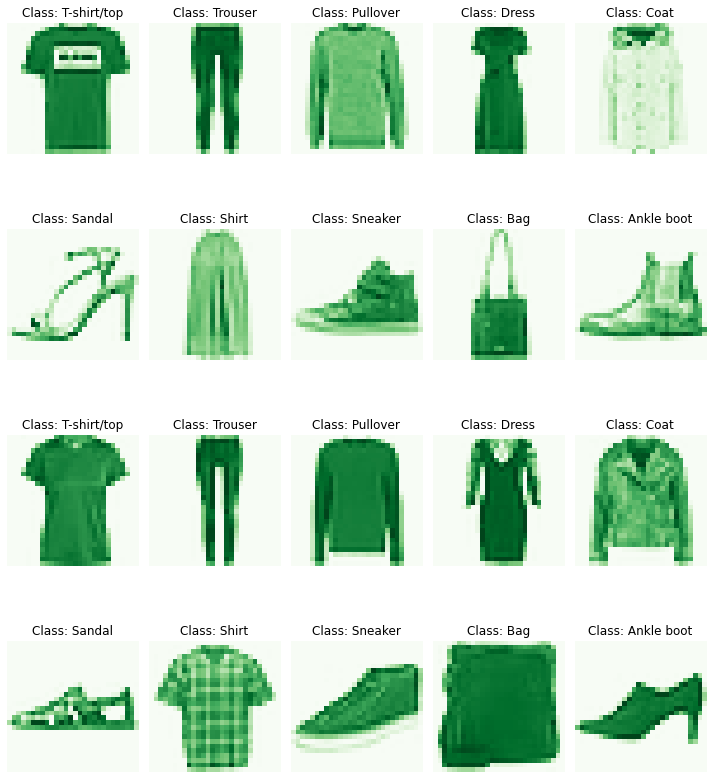

In [89]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(10,12))

for i in range(20):
    plt.subplot(4,5,i+1)
    img = x_train[y_train == (i%10)][i%10+i]
    plt.imshow(img, cmap='Greens', interpolation='none')
    plt.title("Class: {}".format(class_names[i%10]))
    plt.axis('off')
    
plt.tight_layout()

In [107]:
def log_images(x_train, y_train):
    set_images=[]
    set_labels=[]
    count=0
    for d in range(len(y_train)):
        if y_train[d]==count:
            set_images.append(wandb.Image(x_train[d], caption=class_names[y_train[d]]))
            count=count+1
        else:
            pass
        if count==10:
            break
    wandb.log({"Images": set_images})

In [91]:
wandb.init(project="DL_Assignment_1", entity="cs21m010-cs21m041")

In [108]:
log_images(x_train, y_train)

In [22]:
# turn the data into an appropriate matrix form
x_train = np.reshape(x_train, (54000, 784, 1))
y_train = np.reshape(y_train, (54000, 1))

In [23]:
x_test = np.reshape(x_test, (10000, 784, 1))
y_test = np.reshape(y_test, (10000, 1))

In [24]:
x_val = np.reshape(x_val, (6000, 784, 1))
y_val = np.reshape(y_val, (6000, 1))

In [25]:
# One-hot encoding
targs = np.zeros((54000, 10, 1))
for i in range(54000):
    targs[i][y_train[i][0]-1][0] = 1 # preparing the target matrix 

In [26]:
targs_test = np.zeros((10000, 10, 1))
for i in range(10000):
    targs_test[i][y_test[i][0]-1][0] = 1 # preparing the target matrix 

In [27]:
targs_val = np.zeros((6000, 10, 1))
for i in range(6000):
    targs_val[i][y_val[i][0]-1][0] = 1 # preparing the target matrix 

In [28]:
# normalize data
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

In [122]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs, n_layers, config):
    network = list()
    randomMultiplier = 0.01
    
    for i in range(n_layers):
        hidden_layer = {}
        weights = None
        bias = None
        if i==0:
            if config.initialization=="random":
                weights = randomMultiplier * np.random.randn(n_hidden, n_inputs)
            else:
                weights = randomMultiplier * (np.random.randn(n_hidden, n_inputs)) 
                if config.activation == "relu":
                    weights = weights * math.sqrt(2 / n_inputs)
                else:
                    weights = weights * math.sqrt(1 / n_inputs)
            bias = np.zeros([n_hidden, 1])
        else:
            if config.initialization=="random":                                  
                weights = randomMultiplier * np.random.randn(n_hidden, n_hidden)
            else:
                weights = randomMultiplier * (np.random.randn(n_hidden, n_hidden)) 
                if config.activation == "relu":
                    weights = weights * math.sqrt(2 / n_inputs)
                else:
                    weights = weights * math.sqrt(1 / n_inputs)
                                              
            bias = np.zeros([n_hidden, 1])

        hidden_layer['weights'] = weights
        hidden_layer['bias'] = bias
        network.append(hidden_layer)
    
    # Weights and bias for output layer
    output_layer = {}
    if config.initialization=="random":                                  
        weights = randomMultiplier * np.random.randn(n_outputs, n_hidden)
    else:
        weights = randomMultiplier * (np.random.randn(n_outputs,n_hidden)) 
        if config.activation == "relu":
              weights = weights * math.sqrt(2 / n_inputs)
        else:
              weights = weights * math.sqrt(1 / n_inputs)                                        
#     weights = randomMultiplier * np.random.randn(n_outputs, n_hidden)
    bias = np.zeros([n_outputs, 1])
    output_layer['weights'] = weights
    output_layer['bias'] = bias
    network.append(output_layer)
    
    return network

In [123]:
### Activation Functions starts

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def sigmoidGrad(dA, prevZ):
    s = sigmoid(prevZ)
    dZ = dA * s * (1 - s)
    return dZ

def relu(Z):
    A = np.maximum(0, Z)
    return A
    
def reluGrad(dA, prevZ):
    s = np.maximum(0, prevZ)
    dZ = (s>0) * 1 * dA
    return dZ 

def tanh(Z):
    A = np.tanh(Z)
    return A

def tanhGrad(dA, prevZ):
    s = np.tanh(prevZ)
    dZ = (1 - s**2) * dA
    return dZ

def linear(Z):
    return Z
 
def softmax(Z):
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)

def crossEntropyLoss(Y, A, epsilon=1e-15):
    m = Y.shape[1]
    loss = -1 * (Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
    cost = 1 / m * np.sum(loss)
    return np.squeeze(cost)

### Activation Functions ends

In [124]:
# Intializing activationForward and activationBackward globally
activationForward = None
activationBackward = None

# Function to set forward and backward activation functions
def setActivationFns(activationName):
    global activationForward
    global activationBackward

    print('setting activation function as: ', activationName)
    if activationName == 'sigmoid':
        activationForward = sigmoid
        activationBackward = sigmoidGrad
    elif activationName == 'tanh':
        activationForward = tanh
        activationBackward = tanhGrad
    elif activationName == 'relu':
        activationForward = relu
        activationBackward = reluGrad
    else:
        print('invalid activation name') 


In [125]:
loss = None

def setLossFns(lossFunction):
    global loss
    
    if lossFunction == 'crossEntropy':
        loss = 'crossEntropy'
    else:
        loss= 'squaredError'
    

In [126]:
# Method to print Accuracy
def printAccuracy(network, x_test, targs_test):
    predictedCorrect = 0
    predictedWrong = 0
    for n in range(len(x_test)):
        ins = x_test[n]
        A = forward_propagate(network, ins)
        classPredicted = np.argmax(A, axis=0)[0]
        classActual = np.argmax(targs_test[n], axis=0)[0]
        if (classPredicted == classActual):
            predictedCorrect = predictedCorrect + 1
        else:
            predictedWrong = predictedWrong + 1
    accuracy = predictedCorrect / len(x_test) 
    print('Accuracy: ', accuracy)
    return accuracy

In [127]:
#Method to print Confusion Matrix

def predict_label(network,x_test,targs_test,y_test):
    acc = 0
    y_pred=[]

    for n in range(len(x_test)):
        ins = x_test[n]
        A = forward_propagate(network, ins)
        classPredicted = np.argmax(A, axis=0)[0]
        classPredicted=(classPredicted+1)%10
        classActual = np.argmax(targs_test[n], axis=0)[0]
        if (classPredicted == classActual):
            acc = acc + 1
        y_pred.append(classPredicted)

    print("Accuracy: ",str((acc/len(y_test))*100),"%")
    cm=metrics.confusion_matrix(y_true=y_test,y_pred=y_pred)
    df_cm = pd.DataFrame(cm, index=[i for i in class_names],
              columns=[i for i in class_names])
    print(df_cm)
    plt.figure(figsize=(10, 10))
    ax = sn.heatmap(df_cm, annot=True,  cmap='Greens', fmt='d',linewidths=3, linecolor='black')
    ax.set_yticklabels(class_names,rotation=0)
    plt.xlabel("True Class")  # x-axis label
    plt.ylabel("Predicted Class")  # y-axis label
    plt.title('Confusion Matrix of FASHION-MNIST Dataset', fontsize=20)
    plt.show()

In [128]:
### Common Utils Starts

def resetdbanddW(network):
    for layer in network:
        m, n = layer['weights'].shape
        layer['dW'] = np.zeros([m, n])
        m, n = layer['bias'].shape
        layer['db'] = np.zeros([m, n])

def initialize_v_w_and_v_b(network):
    for layer in network:
        m, n = layer['weights'].shape
        layer['v_w'] = np.zeros([m, n])
        m, n = layer['bias'].shape
        layer['v_b'] = np.zeros([m, n])

def update_v_w_and_v_b(network, gamma):
    for layer in network:
        layer['v_w'] = gamma * layer['prev_v_w']
        layer['v_b'] = gamma * layer['prev_v_b']

def initialize_prev_v_w_and_prev_v_b(network):
    for layer in network:
        m, n = layer['weights'].shape
        layer['prev_v_w'] = np.zeros([m, n])
        m, n = layer['bias'].shape
        layer['prev_v_b'] = np.zeros([m, n])

### Common Utils Ends

In [129]:
setActivationFns("sigmoid")

setting activation function as:  sigmoid


In [130]:
# Forward propagate input to a network output

def forward_propagate(network, X):
    x = np.copy(X)

    # Apply sigmoid for all previous layers
    for layer in network[:-1]:
        Z = np.dot(layer['weights'], x) + layer['bias']
        layer['prevZ'] = Z  # Preactivation values of current layer
        layer['prevA'] = x  # Activation values of previous layer
        x = activationForward(Z) 

    # Apply softmax for the final layer
    layer = network[-1]
    Z = np.dot(layer['weights'], x) + layer['bias']
    layer['prevZ'] = Z
    layer['prevA'] = x
    x = softmax(Z)
    return x

In [131]:
# Back propagation
def backward_propagation(network, actual, predicted):

    global loss
    if loss=="crossEntropy":
        dZ = -(actual - predicted)
    else:
        y_label = predicted[np.argmax(actual)]
        dZ = 2 * (y_label - 1) * y_label * ( actual - predicted )

    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] +  1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [132]:
def update(network, learning_rate):
    for layer in network:
        layer['weights'] = layer['weights'] - learning_rate * layer['dW']
        layer['bias'] = layer['bias'] - learning_rate * layer['db']

In [133]:
# Stochastic Gradient Descent

In [134]:
def optimser_sgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        no_of_steps=0
        resetdbanddW(network)
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update(network, config.learning_rate)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)
      

In [135]:
def calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost):
    epoch+=1
    total_cost_val=0
    for n in range(6000):
        ins = x_val[n]
        target = targs_val[n]
        A = forward_propagate(network, ins)
        total_cost_val = total_cost_val + crossEntropyLoss(target, A)

    accuracy_val = printAccuracy(network, x_val, targs_val)
    accuracy_test = printAccuracy(network, x_test, targs_test)
    total_cost = total_cost / 54000 
    total_cost_val = total_cost_val / 6000
    wandb.log({"val_loss": total_cost_val, "val_accuracy": accuracy_val, "loss": total_cost, "accuracy": accuracy_test, "epochs": epoch })



In [136]:
# Momentum Gradient Descent

In [137]:
# Back propagation for mgd
def backward_propagation_mgd(network, actual, predicted):
    global loss
    if loss=="crossEntropy":
        dZ = -(actual - predicted)
    else:
        y_label = predicted[np.argmax(actual)]
        dZ = 2 * (y_label - 1) * y_label * ( actual - predicted )

    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] + 1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [138]:
def update_mgd(network, learning_rate, gamma):
    for layer in network:
        v_w = gamma * layer['prev_v_w'] + learning_rate * layer['dW']
        v_b = gamma * layer['prev_v_b'] + learning_rate * layer['db']

        layer['weights'] = layer['weights'] - v_w
        layer['bias'] = layer['bias'] - v_b

        layer['prev_v_w'] = v_w
        layer['prev_v_b'] = v_b

In [139]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=784
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('tanh')

In [140]:
def optimser_mgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_prev_v_w_and_prev_v_b(network)
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        resetdbanddW(network)
        no_of_steps=0
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation_mgd(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update_mgd(network, config.learning_rate, gamma=0.9)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

In [141]:
# Nesterov Accelerated Gradient Descent

In [142]:
# Forward propagate for NAGD
def forward_propagate_nagd(network, X):
    x = np.copy(X)
    nagdx = np.copy(X)

    # Apply activationForward for all previous layers
    for layer in network[:-1]:
        Z = np.dot(layer['weights'], x) + layer['bias']
        nagdZ = np.dot(layer['weights'] - layer['v_w'], nagdx) + layer['bias'] - layer['v_b']
        
        layer['prevZ'] = Z  # Preactivation values of current layer
        layer['prevA'] = x  # Activation values of previous layer

        layer['prevnagdZ'] = nagdZ  # Preactivation values of current layer
        layer['prevnagdA'] = nagdx # Activation values of previous layer

        x = activationForward(Z) 
        nagdx = activationForward(nagdZ)

    # Apply softmax for the final layer
    layer = network[-1]
    Z = np.dot(layer['weights'], x) + layer['bias']
    nagdZ = np.dot(layer['weights'] - layer['v_w'], nagdx) + layer['bias'] - layer['v_b']
    layer['prevZ'] = Z
    layer['prevA'] = x
    layer['prevnagdZ'] = nagdZ
    layer['prevnagdA'] = nagdx
    # x = softmax(Z)
    nagdx = softmax(nagdZ)
    return nagdx

In [143]:
# Back propagation for NAGD
def backward_propagation_nagd(network, actual, predicted):
    global loss
    if loss=="crossEntropy":
        dZ = -(actual - predicted)
    else:
        y_label = predicted[np.argmax(actual)]
        dZ = 2 * (y_label - 1) * y_label * ( actual - predicted )

    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] + 1 / m * np.dot(dZ, network[i]['prevnagdA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevnagdZ'])

In [144]:
# Update for nagd
def update_nagd(network, learning_rate, gamma):
    for layer in network:
        v_w = gamma * layer['prev_v_w'] + learning_rate * layer['dW']
        v_b = gamma * layer['prev_v_b'] + learning_rate * layer['db']

        layer['weights'] = layer['weights'] - v_w
        layer['bias'] = layer['bias'] - v_b

        layer['prev_v_w'] = v_w
        layer['prev_v_b'] = v_b

In [145]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=784
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('relu')

In [146]:
def optimser_nagd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_prev_v_w_and_prev_v_b(network)
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        resetdbanddW(network)
        no_of_steps=0
        update_v_w_and_v_b(network, gamma=0.9)
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate_nagd(network, ins)
            backward_propagation_nagd(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update_nagd(network, config.learning_rate, gamma=0.9)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

In [147]:
# RMSProp

In [148]:
# Back propagation for mgd
def backward_propagation_rmsprop(network, actual, predicted):
    global loss
    if loss=="crossEntropy":
        dZ = -(actual - predicted)
    else:
        y_label = predicted[np.argmax(actual)]
        dZ = 2 * (y_label - 1) * y_label * ( actual - predicted )

    for i in range(len(network) - 1, -1, -1):
        # print(network[i]['prevA'])
        m = network[i]['prevA'].shape[1]
        network[i]['dW'] = network[i]['dW'] + 1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] = network[i]['db'] + 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [149]:
def update_rmpsprop(network, learning_rate, beta1, eps=1e-8):
    for layer in network:
      layer['v_w'] = beta1 * layer['v_w'] + (1 - beta1) * layer['dW']**2
      layer['v_b'] = beta1 * layer['v_b'] + (1 - beta1) * layer['db']**2

      layer['weights'] = layer['weights'] - (learning_rate / np.sqrt(layer['v_w'] + eps)) * layer['dW']
      layer['bias'] = layer['bias'] - (learning_rate / np.sqrt(layer['v_b'] + eps)) * layer['db']

In [150]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=784
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('sigmoid')

In [151]:
def optimser_rmsprop(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_v_w_and_v_b(network)
    eps, beta1 = 1e-8, 0.9
    for epoch in range(config.number_of_epochs):
        total_cost = 0
        # Do reset accumulated db and dW here
        resetdbanddW(network)
        no_of_steps=0
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation_rmsprop(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                update_rmpsprop(network, config.learning_rate, beta1=beta1, eps=eps)
                resetdbanddW(network)
                no_of_steps=0
            total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

In [152]:
# Adam

In [153]:
def backward_propagation_adam(network, actual, predicted):
    global loss
    if loss=="crossEntropy":
        dZ = -(actual - predicted)
    else:
        y_label = predicted[np.argmax(actual)]
        dZ = 2 * (y_label - 1) * y_label * ( actual - predicted )

    for i in range(len(network) - 1, -1, -1):

        m = network[i]['prevA'].shape[1]
        network[i]['dW'] += 1 / m * np.dot(dZ, network[i]['prevA'].T)
        network[i]['db'] += 1 / m * np.sum(dZ)
        prevdA = np.dot(network[i]['weights'].T, dZ)
        if i != 0:
            dZ = sigmoidGrad(prevdA, network[i-1]['prevZ'])

In [154]:
def update_adam(network, epoch, learning_rate, beta1, beta2, optimizer):
    
        for layer in network:
            if epoch!=0:
                layer['m_w']=beta1*layer['m_w'] + (1-beta1)*layer['dW']
                layer['m_b']=beta1*layer['m_b'] + (1-beta1)*layer['db']

                layer['v_w']=beta2*layer['v_w'] + (1-beta2)*np.square(layer['dW'])
                layer['v_b']=beta2*layer['v_b'] + (1-beta2)*np.square(layer['db'])

            else:
                layer['m_w']= (1-beta1)*layer['dW']
                layer['m_b']= (1-beta1)*layer['db']

                layer['v_w']=(1-beta2)*np.square(layer['dW'])
                layer['v_b']= (1-beta2)*np.square(layer['db'])

            if optimizer=="adam":
                layer['m_w_hat']=layer['m_w']/(1-math.pow(beta1,epoch+1))
            else:
                layer['m_w_hat']=layer['m_w']*beta1+(1-beta1)*layer['dW']/(1-math.pow(beta1,epoch+1))
                
            layer['m_b_hat']=layer['m_b']/(1-math.pow(beta1,epoch+1))

            layer['v_w_hat']=layer['v_w']/(1-math.pow(beta2,epoch+1))
            layer['v_b_hat']=layer['v_b']/(1-math.pow(beta2,epoch+1))
        
        
            layer['weights'] = layer['weights'] - (learning_rate / np.sqrt(layer['v_w_hat'] + learning_rate))*layer['m_w_hat'] 
            layer['bias'] = layer['bias'] - (learning_rate / np.sqrt(layer['v_b_hat'] + learning_rate))*layer['m_b_hat']


In [155]:
# seed(1)
# no_of_inputs=784
# no_of_neurons_in_hidden_layer=10
# no_of_classes=10
# no_of_hidden_layers=2
# network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers)
# setActivationFns('sigmoid')

In [156]:
def optimser_adam(network, config, x_train, targs, x_val, targs_val, x_test, targs_test):
    setActivationFns(config.activation)
    initialize_prev_v_w_and_prev_v_b(network)
    for epoch in range(config.number_of_epochs):
        no_of_steps=0
        beta1,beta2=0.9,0.999
        total_cost=0
        resetdbanddW(network)
        for n in range(54000):
            ins = x_train[n]
            target = targs[n]
            A = forward_propagate(network, ins)
            backward_propagation_adam(network, target, A)
            no_of_steps+=1
            if no_of_steps%config.batch_size==0:
                  update_adam(network, epoch, config.learning_rate, beta1, beta2,config.optimizer)
                  resetdbanddW(network)
                  no_of_steps=0
        total_cost = total_cost + crossEntropyLoss(target, A)
        print('Total cost for this epoch: ', total_cost)
        if epoch==4 or config.loss:
            calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost)

    calculate_loss_and_accuracy(network, config, x_train, targs, x_val, targs_val, x_test, targs_test, epoch, total_cost) 

In [157]:
sweep_config = {
  "name" : "Final_sweep",
  "method" : "random",
  "parameters" : {
    "neurons_hidden_layer" : {
      "values" : [32, 64, 128]
      # "values" : [32]
    },
    "number_of_epochs" : {
        "values" : [5,10]
        # "values" : [10]
    },
    "activation" : {
        "values" : ["sigmoid" , "relu" , "tanh"]
    },
    "no_of_hidden_layer" : {
      "values" : [3, 4, 5]
      # "values" : [2]
    },
    "batch_size" :{
      "values" : [16,32,64]
    },
    "optimizer" : {
        "values" : ["adam", "rmsprop" ,"nadam" , "sgd" , "momentum" , "nesterov"]
        # "values" : ["adam"]
    },
    "initialization": {
      "values" : ["random", "xavier"]  
    },
    "weight_decay" : {
        "values" : [0, 0.0005, 0.5]
    },
    "learning_rate" :{
      "values" : [0.1,0.01,0.001]
    }
  }
}
sweep_id = wandb.sweep(sweep_config,project="DL_Assignment_1",entity="cs21m010-cs21m041")

Create sweep with ID: 295hvqcv
Sweep URL: https://wandb.ai/cs21m010-cs21m041/DL_Assignment_1/sweeps/295hvqcv


In [158]:
def train(config=None):

    # Initialize a new wandb run
    with wandb.init(config=config) as run:

        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
        # hl_3_bs_16_ac_tanh 
        if config.loss:
            setLossFns(config.loss)
            sweep_name = '{}'.format(config.loss)

        else:
            setLossFns('crossEntropy')
            sweep_name = 'hl_{}_bs_{}_ac_{}_{}'.format(config.no_of_hidden_layer, config.batch_size, config.activation, config.optimizer)

        print(sweep_name)
        run.name = sweep_name
        
        np.random.seed(0)
        no_of_inputs=784
        no_of_neurons_in_hidden_layer=config.neurons_hidden_layer
        no_of_classes=10
        no_of_hidden_layers=config.no_of_hidden_layer
        network = initialize_network(no_of_inputs, no_of_neurons_in_hidden_layer, no_of_classes, no_of_hidden_layers, config )
        
        

        if config.optimizer=="sgd":
            optimser_sgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="momentum":
            optimser_mgd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="nesterov":
            optimser_nagd(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="rmsprop":
            optimser_rmsprop(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        elif config.optimizer=="adam":
            optimser_adam(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)
        else:
            optimser_adam(network, config, x_train, targs, x_val, targs_val, x_test, targs_test)

        if 'loss' in config.keys() and config.loss=='crossEntropy':
          print("came here")
          predict_label(network,x_test,targs_test,y_test)



In [159]:
# wandb.agent(sweep_id, train, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 8msmoafr
Sweep URL: https://wandb.ai/cs21m010-cs21m041/DL_Assignment_1/sweeps/8msmoafr


wandb: Agent Starting Run: cfmae127 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: crossEntropy
wandb: 	neurons_hidden_layer: 128
wandb: 	no_of_hidden_layer: 3
wandb: 	number_of_epochs: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


crossEntropy
setting activation function as:  sigmoid
Total cost for this epoch:  0.013690390472964248
Accuracy:  0.6318333333333334
Accuracy:  0.6299
Total cost for this epoch:  0.02903000987920053
Accuracy:  0.8388333333333333
Accuracy:  0.8364
Total cost for this epoch:  0.02289792279621886
Accuracy:  0.8616666666666667
Accuracy:  0.8526
Accuracy:  0.8616666666666667
Accuracy:  0.8526
came here
Accuracy:  0.43 %
             T-shirt/top  Trouser  Pullover  ...  Sneaker  Bag  Ankle boot
T-shirt/top          813        2        10  ...        0    8           0
Trouser                3      955         7  ...        0    0           0
Pullover              13        0       806  ...        0    0           0
Dress                 38       19        13  ...        0    4           0
Coat                   1        0       167  ...        0    4           0
Sandal                 0        0         0  ...       26    6          27
Shirt                144        1       105  ...        

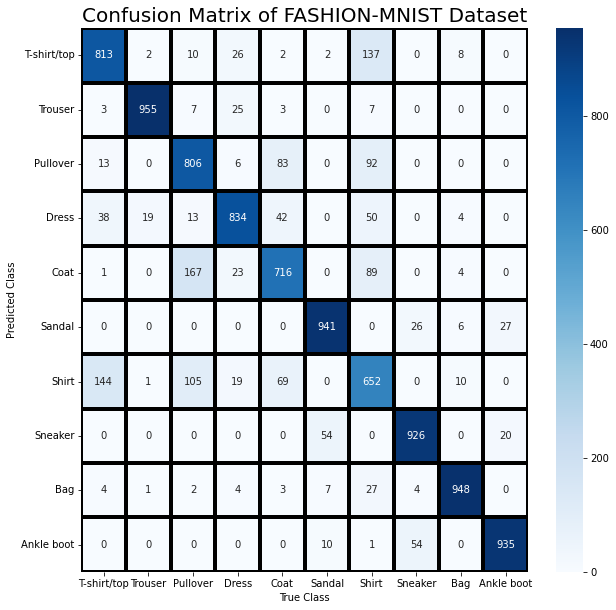

accuracy,▁▇██
epochs,▁▅██
loss,▁█▅▅
val_accuracy,▁▇██
val_loss,█▂▁▁
accuracy,0.8526
epochs,3
loss,0.0
val_accuracy,0.86167
val_loss,0.693


wandb: Agent Starting Run: 077881g1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	initialization: xavier
wandb: 	learning_rate: 0.01
wandb: 	loss: crossEntropy
wandb: 	neurons_hidden_layer: 128
wandb: 	no_of_hidden_layer: 3
wandb: 	number_of_epochs: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0


crossEntropy
setting activation function as:  sigmoid
Total cost for this epoch:  0.013690390472964248
Accuracy:  0.6318333333333334
Accuracy:  0.6299
Total cost for this epoch:  0.02903000987920053
Accuracy:  0.8388333333333333
Accuracy:  0.8364
Total cost for this epoch:  0.02289792279621886
Accuracy:  0.8616666666666667
Accuracy:  0.8526
Accuracy:  0.8616666666666667
Accuracy:  0.8526
came here


wandb: Ctrl + C detected. Stopping sweep.


In [160]:
best_config = {
  "name" : "Best_Sweep",
  "method" : "random",
  "parameters" : {
    "neurons_hidden_layer" : {
      "values" : [128]
    },
    "number_of_epochs" : {
        "values" : [10]
    },
    "activation" : {
        "values" : ["sigmoid"]
    },
    "no_of_hidden_layer" : {
      "values" : [3]
    },
    "batch_size" :{
      "values" : [32]
    },
    "optimizer" : {
        "values" : ["adam"]
    },
    "initialization": {
      "values" : ["xavier"]  
    },
    "weight_decay" : {
        "values" : [0]
    },
    "loss" : {
        # "values" : ["crossEntropy","squaredError"]
        "values" : ["crossEntropy"]
    },
    "learning_rate" :{
      "values" : [0.01]
    }
  }
}

sweep_id = wandb.sweep(best_config,project="DL_Assignment_1",entity="cs21m010-cs21m041")
wandb.agent(sweep_id, train, count=2)


